#### Name    <br>  Rashmi Nagpal
#### Course  <br> Applied Machine Learning


##### Part 1

##### Importing libraries

In [97]:
import time
import numpy as np
import pandas as pd
import os 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, MinMaxScaler

from keras.regularizers import l2
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.utils import np_utils, generic_utils
from keras.optimizers import SGD

from random import randint, uniform

import seaborn as sns
from matplotlib import pyplot
from skimage.io import imshow
from skimage import transform, filters, exposure

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from PIL import Image

In [91]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
from sklearn.metrics import confusion_matrix

In [38]:
def getfileListDF(path, ):
    df_columns = ['fileName', 'class']
    alphabet_df = pd.DataFrame(columns = df_columns)
    alphbetDirs = os.listdir(path)
    for directory in alphbetDirs:
        alphabetclass = int(directory[-2:])
        files = os.listdir(os.path.join(path, directory))
        files = [os.path.join(path, directory, file) for file in files]
        alphabet_class_df = pd.DataFrame(zip(files, [alphabetclass]*len(files)), columns = df_columns)
        alphabet_df = pd.concat([alphabet_df, alphabet_class_df], ignore_index=True)
        
    return alphabet_df
        

In [46]:
badImageDatalist = "datasets/English/Img/BadImag/Bmp"
goodImageDatalist = "datasets/English/Img/GoodImg/Bmp"

In [42]:
badImg_dataframe = getfileListDF(badImageDatalist)
print(badImg_dataframe.shape)
badImg_dataframe.head()

(4798, 2)


,fileName,class
0,datasets/English/Img/BadImag/Bmp/Sample051/img...,51
1,datasets/English/Img/BadImag/Bmp/Sample051/img...,51
2,datasets/English/Img/BadImag/Bmp/Sample051/img...,51
3,datasets/English/Img/BadImag/Bmp/Sample051/img...,51
4,datasets/English/Img/BadImag/Bmp/Sample051/img...,51


In [47]:
goodImg_dataframe = getfileListDF(goodImageDatalist)
print(goodImg_dataframe.shape)
goodImg_dataframe.head()

(7705, 2)


,fileName,class
0,datasets/English/Img/GoodImg/Bmp/Sample051/img...,51
1,datasets/English/Img/GoodImg/Bmp/Sample051/img...,51
2,datasets/English/Img/GoodImg/Bmp/Sample051/img...,51
3,datasets/English/Img/GoodImg/Bmp/Sample051/img...,51
4,datasets/English/Img/GoodImg/Bmp/Sample051/img...,51


In [48]:
combined_dataframe = pd.concat([badImg_dataframe, goodImg_dataframe], ignore_index=True)

##### Splitting Dataset

In [49]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(combined_dataframe, stratify=combined_dataframe['class'], random_state=42, test_size=0.2)

In [50]:
train, val = train_test_split(train, stratify=train['class'], random_state=42, test_size=0.2)

In [51]:
train.shape

(8001, 2)

In [54]:
test.head()

,fileName,class
4348,datasets/English/Img/BadImag/Bmp/Sample024/img...,24
7942,datasets/English/Img/GoodImg/Bmp/Sample011/img...,11
9556,datasets/English/Img/GoodImg/Bmp/Sample038/img...,38
10132,datasets/English/Img/GoodImg/Bmp/Sample014/img...,14
2904,datasets/English/Img/BadImag/Bmp/Sample055/img...,55


In [27]:
val.shape

(2001, 2)

In [79]:
def save_to_dir(dataframe, folder):
    for index, row in dataframe.iterrows():
        folderName = folder + "/" + str(row['class']) + "/"
        if not os.path.exists(folderName):
            os.makedirs(folderName)
        filename = folderName + row['fileName'].split('/')[-1]
        img = Image.open(row['fileName']) 
        img.save(filename)

In [80]:
train_data_folder = "datasets/EnglishImg/training_dataset"
test_data_folder = "datasets/EnglishImg/testing_dataset"
val_data_folder = "datasets/EnglishImg/validation_dataset"

In [81]:
save_to_dir(train,train_data_folder)
save_to_dir(test,test_data_folder)
save_to_dir(val,val_data_folder)

##### Training the CNN model

In [82]:
input_shape = (64, 64, 3)
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D())
model.add(Dropout(0.5))
model.add(Conv2D(64, (5, 5), activation="relu"))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(62, activation="softmax"))
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        51264     


In [83]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [84]:
train_batch_size = 256
val_batch_size = 64
test_batch_size = 64
generated_shape = (64, 64)

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
        train_data_folder,  # this is the target directory
        target_size=generated_shape,  
        batch_size=train_batch_size)

validation_generator = datagen.flow_from_directory(
        val_data_folder,
        target_size=generated_shape,
        batch_size=val_batch_size)

test_generator = datagen.flow_from_directory(
        test_data_folder,
        target_size=generated_shape,
        batch_size=test_batch_size,
        shuffle=False)

Found 6008 images belonging to 62 classes.
Found 1861 images belonging to 62 classes.
Found 2331 images belonging to 62 classes.


In [87]:
model.fit_generator(
        train_generator,
        steps_per_epoch=len(train) // train_batch_size ,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=len(val) // val_batch_size)

Epoch 1/20
31/31 [==============================] - 38s 1s/step - loss: 1.6948 - acc: 0.5431 - val_loss: 1.3607 - val_acc: 0.6488
Epoch 2/20
31/31 [==============================] - 34s 1s/step - loss: 1.5983 - acc: 0.5624 - val_loss: 1.3157 - val_acc: 0.6613
Epoch 3/20
31/31 [==============================] - 34s 1s/step - loss: 1.5403 - acc: 0.5737 - val_loss: 1.2887 - val_acc: 0.6655
Epoch 4/20
31/31 [==============================] - 35s 1s/step - loss: 1.4909 - acc: 0.5753 - val_loss: 1.2130 - val_acc: 0.6945
Epoch 5/20
31/31 [==============================] - 32s 1s/step - loss: 1.4251 - acc: 0.6016 - val_loss: 1.2073 - val_acc: 0.6732
Epoch 6/20
31/31 [==============================] - 29s 937ms/step - loss: 1.3689 - acc: 0.6122 - val_loss: 1.1386 - val_acc: 0.6836
Epoch 7/20
31/31 [==============================] - 34s 1s/step - loss: 1.3016 - acc: 0.6343 - val_loss: 1.1497 - val_acc: 0.6992
Epoch 8/20
31/31 [==============================] - 38s 1s/step - loss: 1.2806 - acc: 0

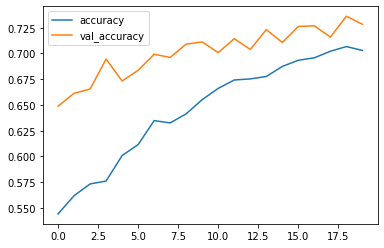

In [93]:
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.legend(["accuracy", "val_accuracy"])
plt.show()

In [94]:
probabilities = model.predict_generator(test_generator)

In [95]:
test_accuracy = (test_generator.classes == np.argmax(probabilities,axis=1)).sum()/len(test_generator.classes)
test_accuracy

0.7262977262977263

In [96]:
y_true = test_generator.classes
y_pred = np.argmax(probabilities,axis=1)
confusion_matrix = confusion_matrix(y_true, y_pred)
confusion_matrix

array([[  3,   0,   0, ...,   0,   0,   0],
       [  0,   8,   0, ...,   0,   0,   0],
       [  0,   1, 151, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   9,   0,   0],
       [  0,   0,   0, ...,   0,   9,   0],
       [  0,   0,   0, ...,   0,   0,   5]])

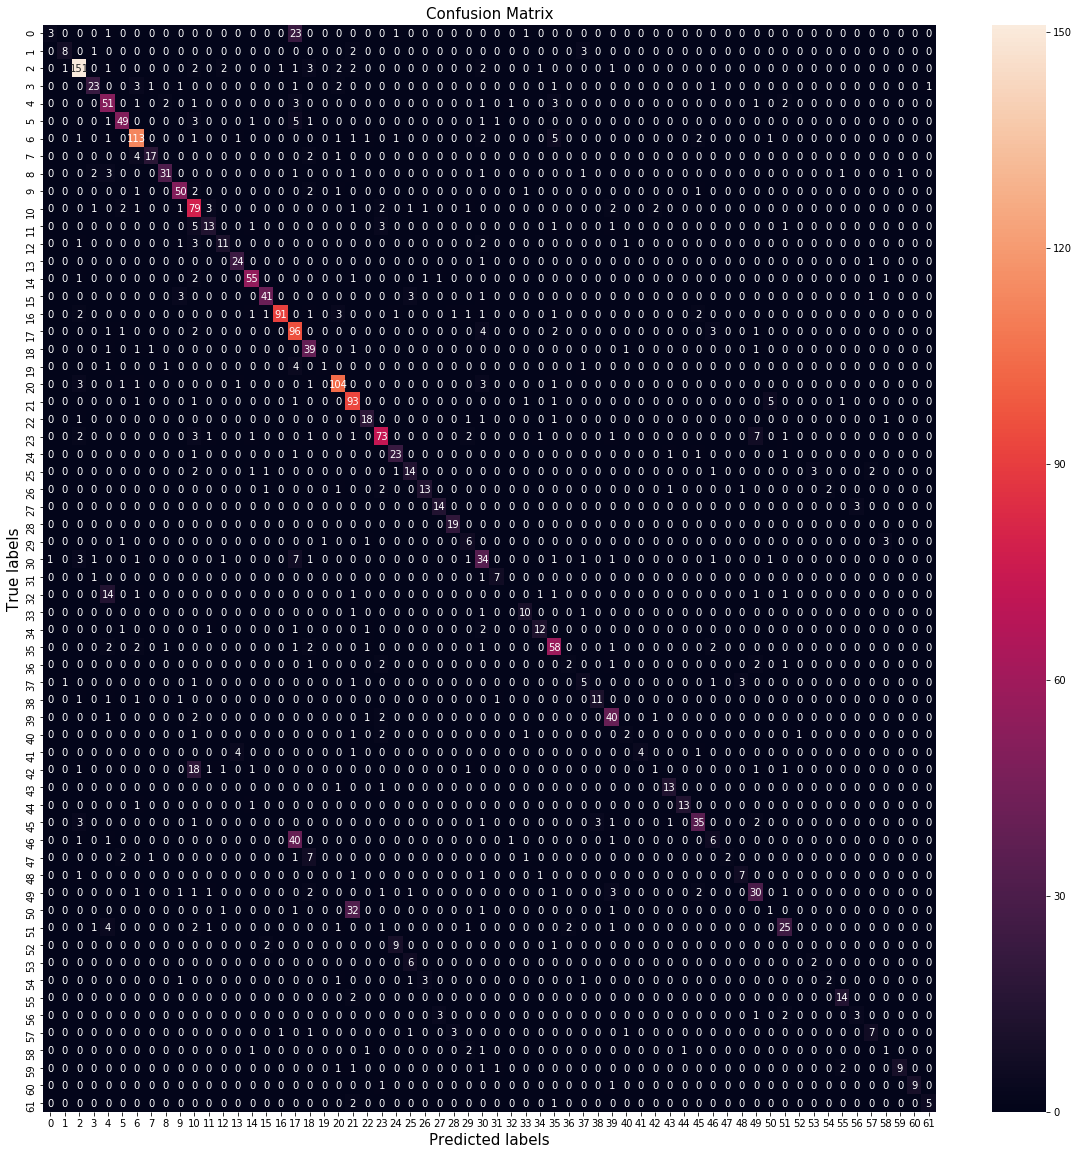

In [99]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(confusion_matrix, annot=True, fmt='d')
ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('True labels', fontsize=15)
ax.set_title('Confusion Matrix', fontsize=15)
plt.savefig('conf.png')
plt.show()

##### From the above confusion matrux, we can interpret that the model has misinterpretated few classes. For example : 5o is misinterpretated as 21, 45 is misinterpretated as 17. 

##### First Convolution Layer

In [100]:
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv2d_1 (3, 3, 3, 32)
conv2d_2 (3, 3, 32, 32)
conv2d_3 (5, 5, 32, 64)


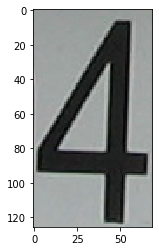

In [105]:

test_img = Image.open("datasets/EnglishImg/testing_dataset/5/img005-00022.png")
plt.imshow(test_img)

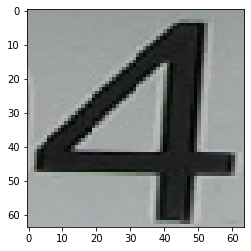

In [106]:
test_img = test_img.resize((64, 64))
plt.imshow(test_img)

In [107]:
# convert the image to an array
test_img = img_to_array(test_img)
# expand dimensions so that it represents a single 'sample'
test_img = expand_dims(test_img, axis=0)

In [108]:
# redefine model to output right after the first hidden layer
firstLayerConv = Model(inputs=model.inputs, outputs=model.layers[0].output)

In [109]:
feature_maps = firstLayerConv.predict(test_img) 

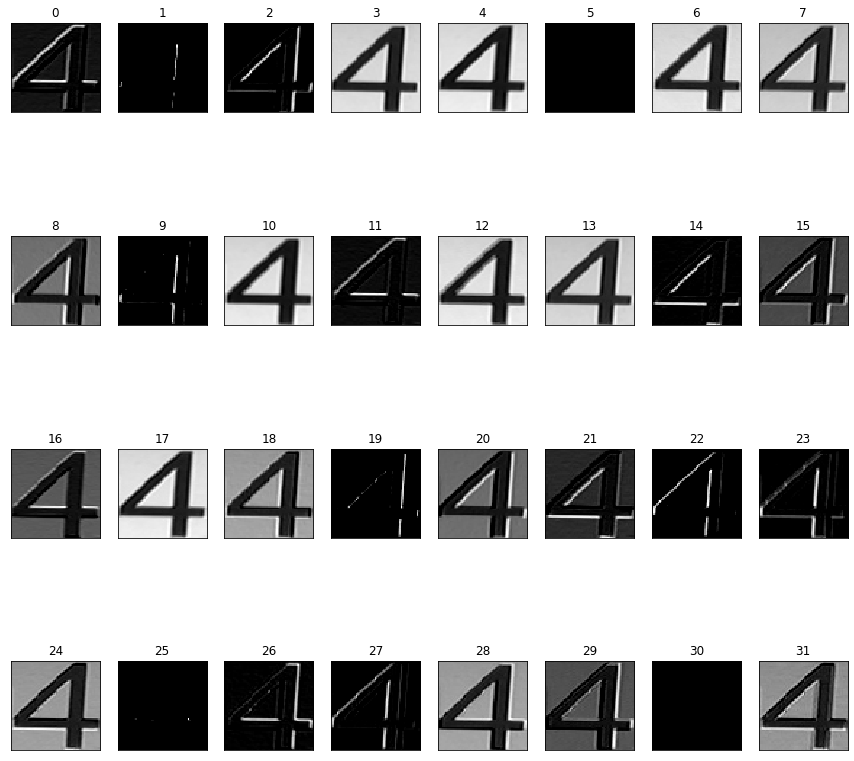

In [114]:
plt.figure(figsize=(15, 15))
for i in range(32):
    ax= plt.subplot(4,8 ,i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(feature_maps[0, :, :, i-1], cmap='gray')
    plt.title(i)
plt.show()

##### Every feature map corresponding to a given image are detecting very basic features from the input image.Like some of them are highlighting the horizontal line, some are verticle, some of them are detecting lines while some blurring lines.

#### Last Convolution Layer

In [121]:
# redefine model to output right after the first hidden layer
lastLayerConv = Model(inputs=model.inputs, outputs=model.layers[5].output)

In [120]:
print(model.layers[5].name)

conv2d_3


In [122]:
feature_maps = lastLayerConv.predict(test_img) 

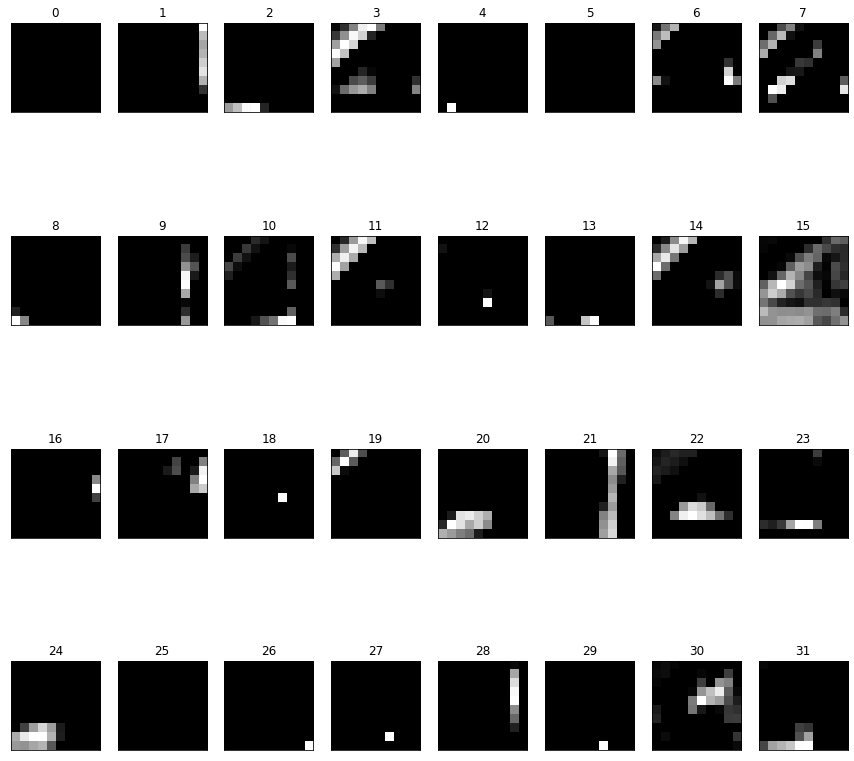

In [123]:
plt.figure(figsize=(15, 15))
for i in range(32):
    ax= plt.subplot(4,8 ,i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(feature_maps[0, :, :, i-1], cmap='gray')
    plt.title(i)
plt.show()

##### It is not clear from the final image that the model has seen a letter 4, we generally lose the ability to interpret these deeper feature maps.

#### Part 2

##### Stride controls how the filter convolves around the input volume

##### Smaller stride means more information to encode therefore better change for better representation. Higher stride means higher step sides and consequently less computation. The idea is in general to use stride larger than 1 to reduce the representational dimension and use stride 1 to keep it same for the next layer. Larger strides lead to lesser overlaps which means lower output volume .  So these are the advantages of higher strides :

* Lesser memory needed for output

* The Output Spatial dimensions are smaller which when given as an input to the next layer simplify the model at least

* It avoids overfitting especially in case of image processing having a large no. of attributes.